# Demo of CNMF

This notebook demonstrates how to use CNMFpy, a package that implements Convolutive Non-Negative Matrix (CNMF) in Python. The goal of CNMF is to minimize the objective

$$ J = \| \hat{X} - X \| $$

where $X$ is a data matrix and $\hat{X}$ is an estimate given by

$$ \hat{X} = W * H = \sum_{l=1}^{L} W_{::l} H_l $$

where $W$ is an $N \times K \times L$ tensor and $H_l$ is the matrix $\mathcal{H}$ with columns shifted right $l$ times and padded with zeros on the left.

This notebook will test CNMFpy on both synthetic data and real data. We will use the regularizer developed by Mackevicius, Bahle, et al in *Unsupervised discovery of temporal sequences in high-dimensional datasets, with applications to neuroscience.*

Our data is calcium imaging and song spectrogram examples from zebra finches, provided by Emily Mackevicius.

## Setup

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import scipy.io

from cnmfpy import CNMF
from cnmfpy.tests import seq_nmf_data

%matplotlib inline

## Generate synthetic data

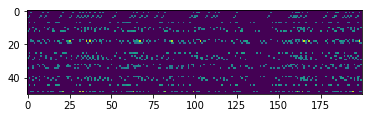

In [24]:
N = 50  # Number of neurons
T = 200  # Length of data in time
L = 10  # Max time lag
K = 2  # Number of factors
sparsity=0.75

data, Wreal, Hreal = seq_nmf_data(N, T, L, K, sparsity)

plt.imshow(data)
plt.show()

## Fit synthetic data

Let's try fitting a simple, single sequence model.

In [25]:
#Hreal /= la.norm(Hreal, axis=-1, keepdims=True)  # normalize

model = CNMF(6, 10, l2_scfo=5e-3, l1_H=0.1, n_iter_max=300, tol=1e-6)
model.fit(data, alg='mult');

 43%|████▎     | 130/300 [00:00<00:00, 255.89it/s]


Reconstruction Error:  0.00195176761767


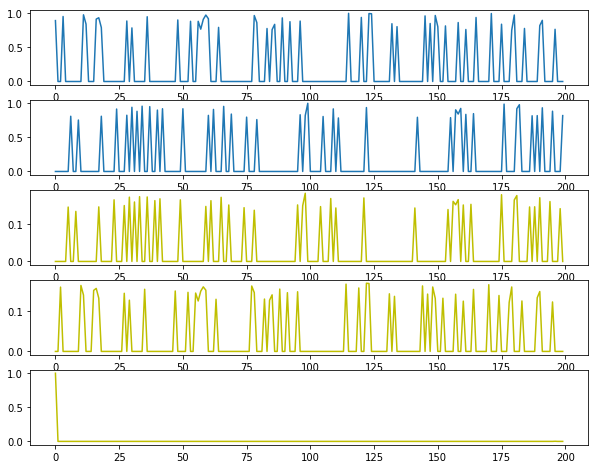

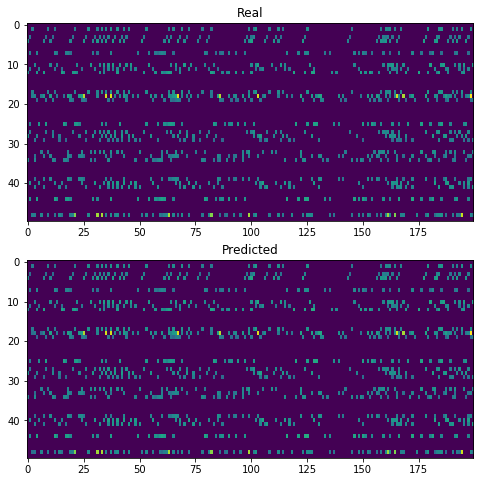

In [26]:
error = data - model.predict()
print('Reconstruction Error: ', norm(error)**2 / norm(data)**2)

plt.figure(figsize=(10,8))
plt.subplot(5,1,1)
plt.plot(range(T), Hreal[0])
plt.subplot(5,1,2)
plt.plot(range(T), Hreal[1])

plt.subplot(5,1,3)
plt.plot(range(T), model.H.shift(0)[0], c='y')
plt.subplot(5,1,4)
plt.plot(range(T), model.H.shift(0)[1], c='y')
plt.subplot(5,1,5)
plt.plot(range(T), model.H.shift(0)[2], c='y')

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(data, aspect='auto')
plt.title('Real')

plt.subplot(2,1,2)
plt.imshow(model.predict(), aspect='auto')
plt.title('Predicted')

plt.show()

## Load songbird data

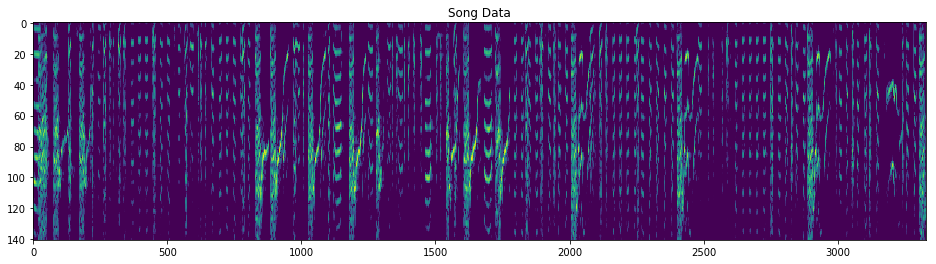

In [27]:
mat_data = scipy.io.loadmat('data/MackeviciusData.mat')
song_data = mat_data['SONG']

song_start = 0
song_end = int((3 / 4.) * song_data.shape[1])

song_train = song_data[:, song_start:song_end]

plt.figure(figsize=(16, 4))
plt.imshow(song_train, aspect='auto')
plt.title('Song Data')
plt.show()

## Fit songbird data

In [67]:
lag = 0.2  # seconds
sL = int(np.ceil(lag * mat_data['SONGfs']))
components = 8

model = CNMF(components, sL, l2_scfo=3e-4, n_iter_max=1000)
model.fit(song_train, alg='mult')


100%|██████████| 1000/1000 [15:25<00:00,  1.08it/s]


Reconstruction Error:  0.603360008812


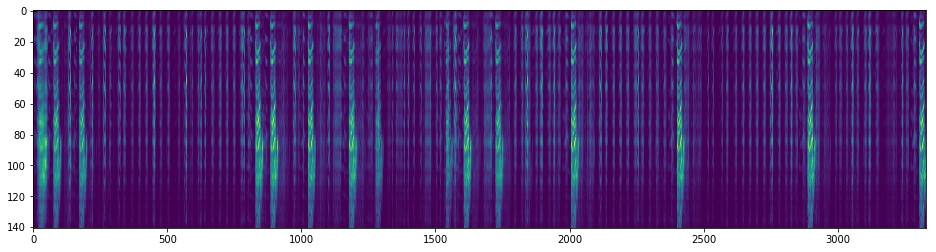

In [73]:
song_est = model.predict()
error = song_est - song_train
print("Reconstruction Error: ", norm(error) / norm(song_train))
plt.figure(figsize=(16,4))
plt.imshow(song_est, aspect='auto')
plt.show()

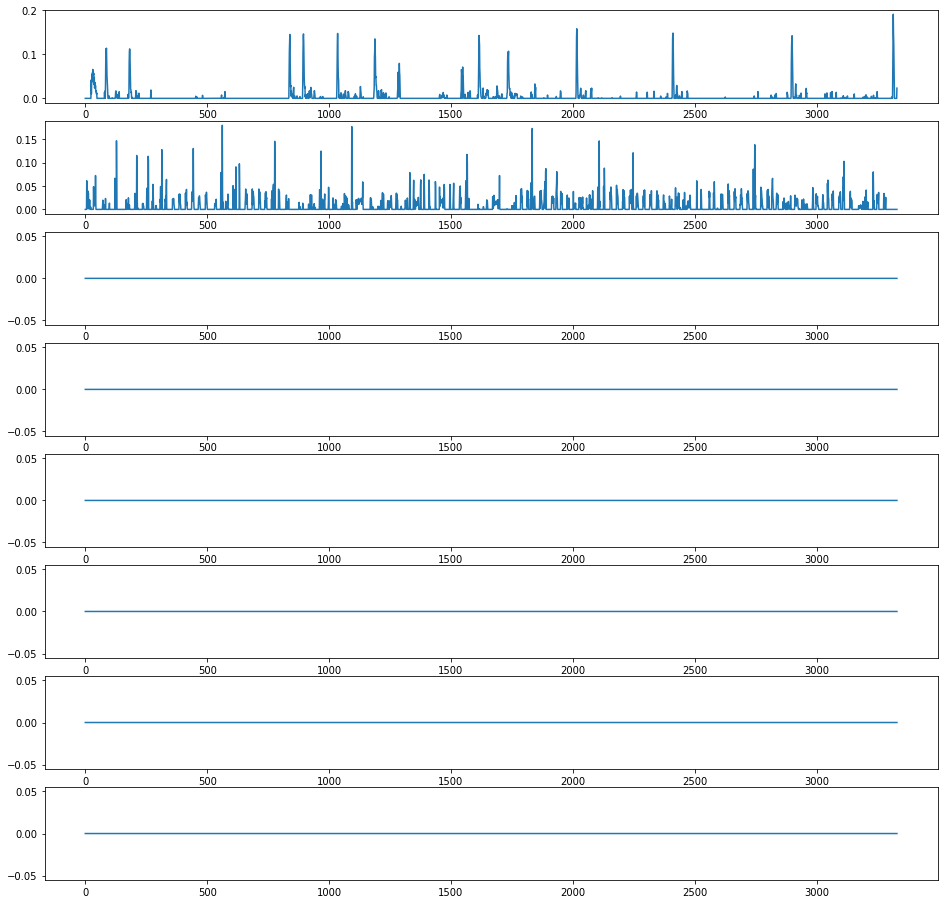

In [69]:
plt.figure(figsize=(16,16))

for i in range(components):
    plt.subplot(components, 1, i+1)
    plt.plot(model.H.shift(0)[i])

## Load calcium imaging data

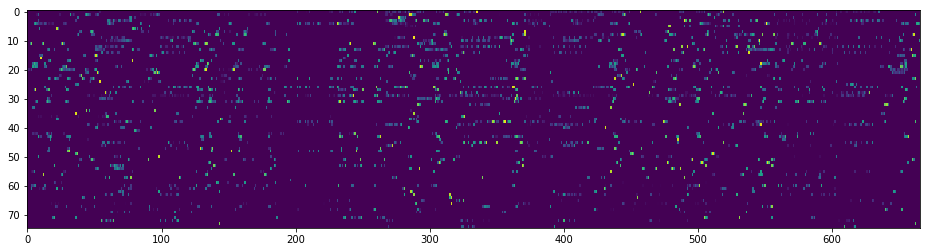

In [28]:
neural_data = mat_data['NEURAL']
lag = 0.7  # seconds
nL = int(np.ceil(lag * mat_data['VIDEOfs']))

plt.figure(figsize=(16, 4))
plt.imshow(neural_data, aspect='auto')
plt.show()

In [49]:
components = 10

model = CNMF(components, nL, l2_scfo=5e-3, l1_W=0.1, n_iter_max=1000, tol=1e-6)
model.fit(neural_data, alg='mult')

 22%|██▏       | 217/1000 [00:05<00:19, 40.49it/s]


Reconstruction Error:  0.544888387541


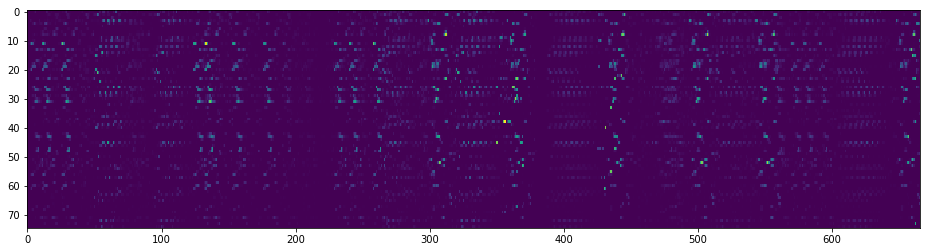

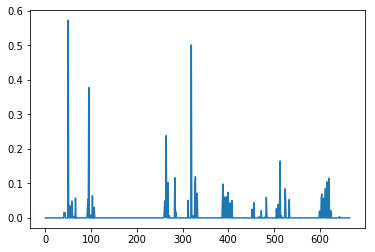

In [50]:
error = model.predict() - neural_data
print('Reconstruction Error: ', norm(error)**2 / norm(neural_data)**2)


plt.figure(figsize=(16,4))
plt.imshow(model.predict(), aspect='auto')
plt.show()

plt.plot(model.H.shift(0)[2])